In [392]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import struct
from glob import glob
import pandas as pd
from cmlreaders import get_data_index, CMLReader
from functools import partial
import scipy
import scipy.signal
from scipy.signal import butter, lfilter

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter(order, [lowcut, highcut], fs=fs, btype='bandpass')
    y = lfilter(b, a, data)
    return y

def rolling_rms(a, n=30):
    ret = np.cumsum(a**2, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.sqrt(ret[n:] / n)

def wavLoad (fname):
    wav = wave.open (fname, "r")
    (nchannels, sampwidth, framerate, nframes, comptype, compname) = wav.getparams()
    frames = wav.readframes (nframes * nchannels)
    out = struct.unpack_from("%dh" % nframes * nchannels, frames)
    
    # Convert 2 channels to numpy arrays
    if nchannels == 2:
        left = np.array(out[::2])
        right = np.array(out[1::2])
    else:
        left = np.array(out)
        right = left
        
    return left, right, wav.getparams()

def contiguous_regions(condition):
    """Finds contiguous True regions of the boolean array "condition". Returns
    a 2D array where the first column is the start index of the region and the
    second column is the end index."""

    # Find the indicies of changes in "condition"
    d = np.diff(condition)
    idx, = d.nonzero() 

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the index by 1 to the right.
    idx += 1

    if condition[0]:
        # If the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition[-1]:
        # If the end of condition is True, append the length of the array
        idx = np.r_[idx, condition.size] # Edit

    # Reshape the result into two columns
    idx.shape = (-1,2)
    return idx

def apply_to_index(df, func):
    subjects = df["subject"].unique()
    
    data = {}
    for sub in subjects:
        experiments = df.query("subject == @sub")["experiment"].unique()
        
        data[sub] = {}
        for exp in experiments:
            data[sub][exp] = {}
            
            sessions = df.query("subject == @sub and experiment == @exp")["session"].unique()
            for sess in sessions:
                try:
                    data[sub][exp][sess] = func(sub, exp, sess)
                except Exception as e:
                    print(f"Error with {exp}:{sess} for {sub}")
                    print(e)
    return data

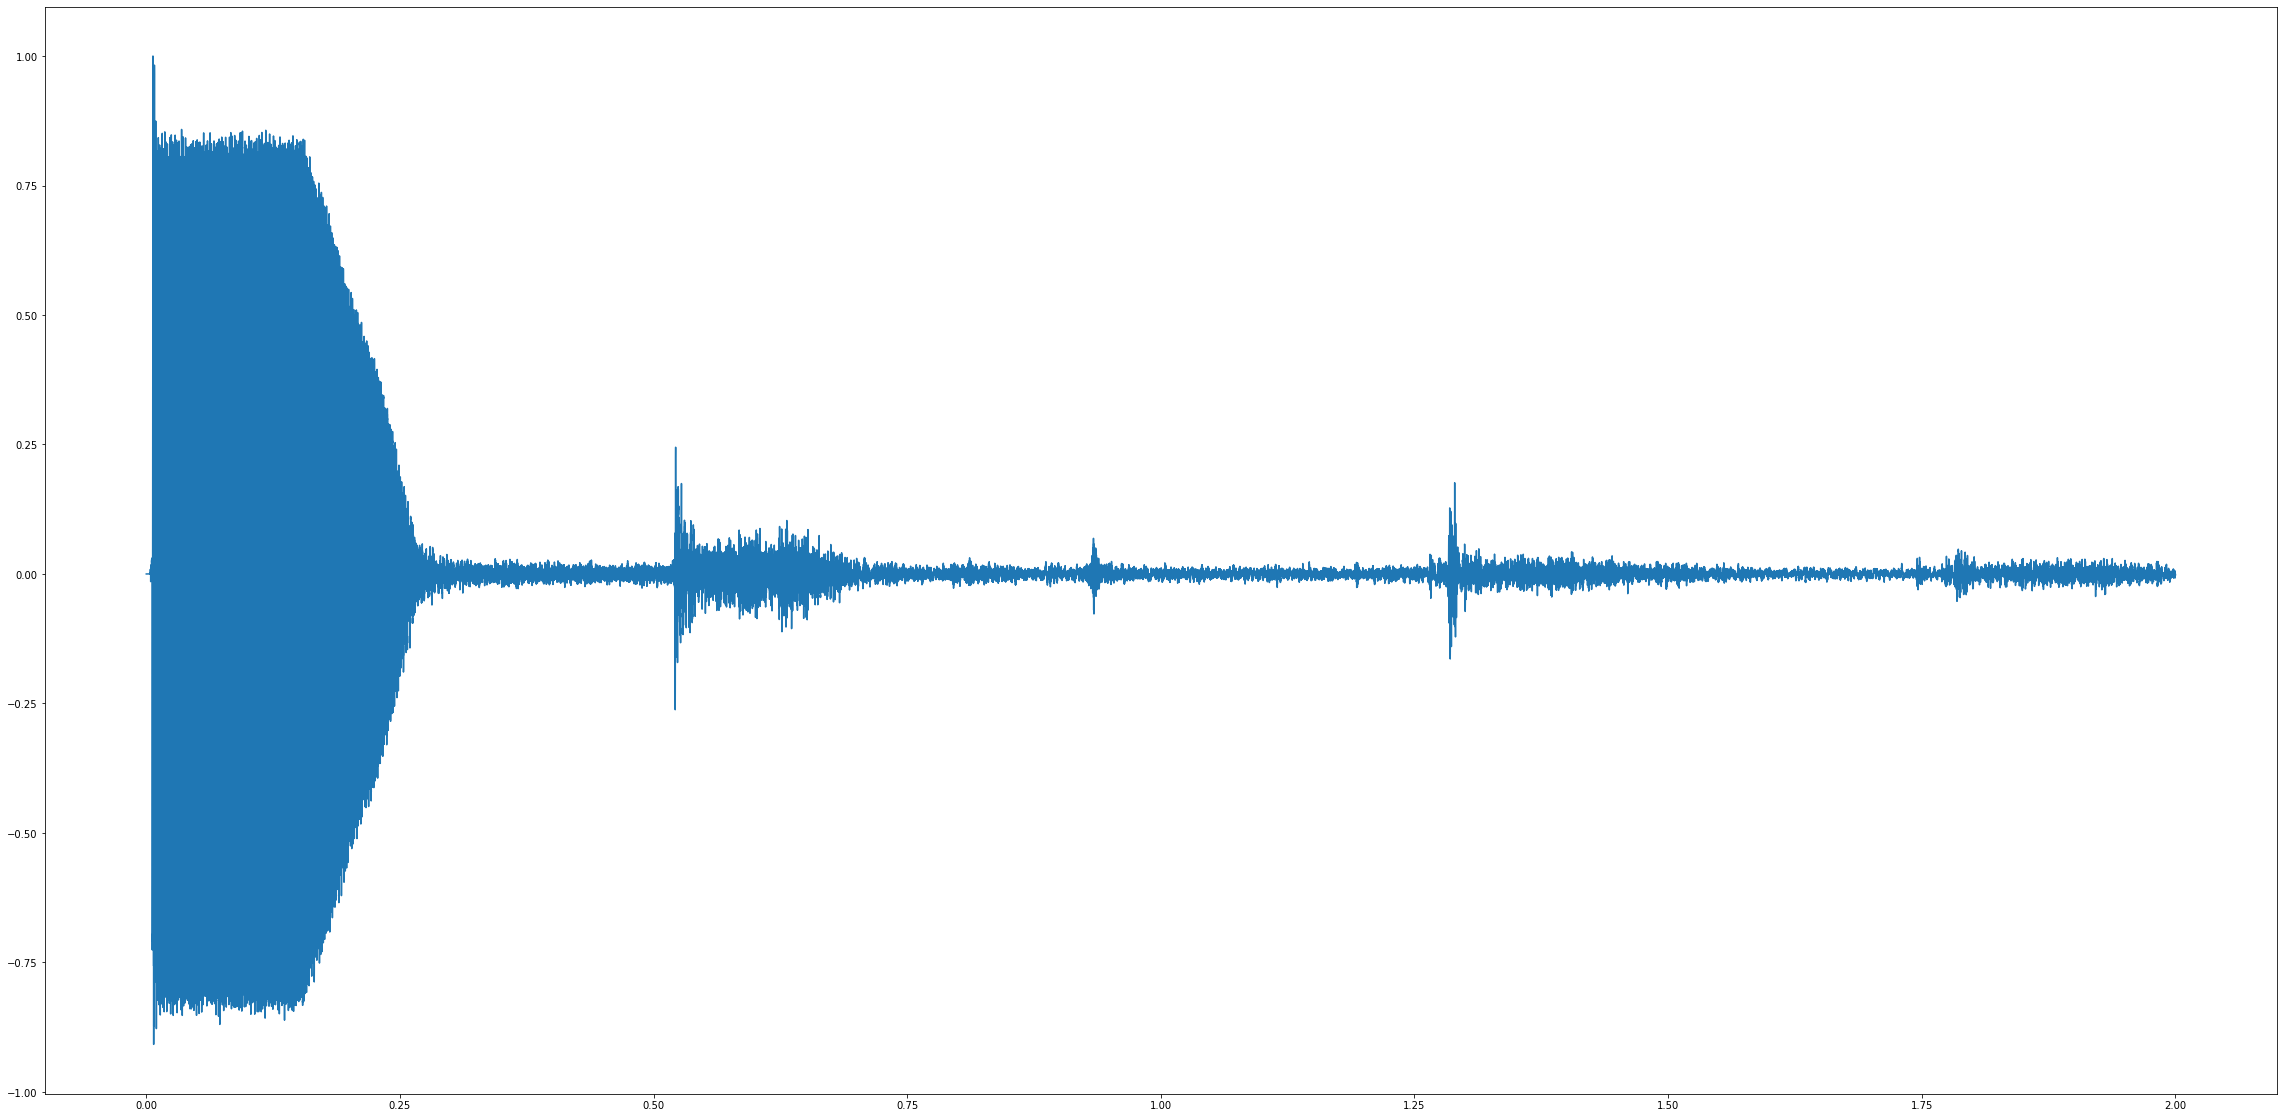

In [528]:
file = "/data10/RAM/subjects/R1402E/behavioral/FR1/session_0/0.wav"
left, right, params = wavLoad(file)
left = left[:int(2 * params.framerate)]
left = left / max(np.abs(left))

times = np.arange(params.nframes)[:left.shape[0]] / params.framerate
plt.figure(figsize=(40, 20))
plt.plot(times, left)
plt.show()

In [529]:
import IPython
IPython.display.Audio(data=left, rate=params.framerate/4)

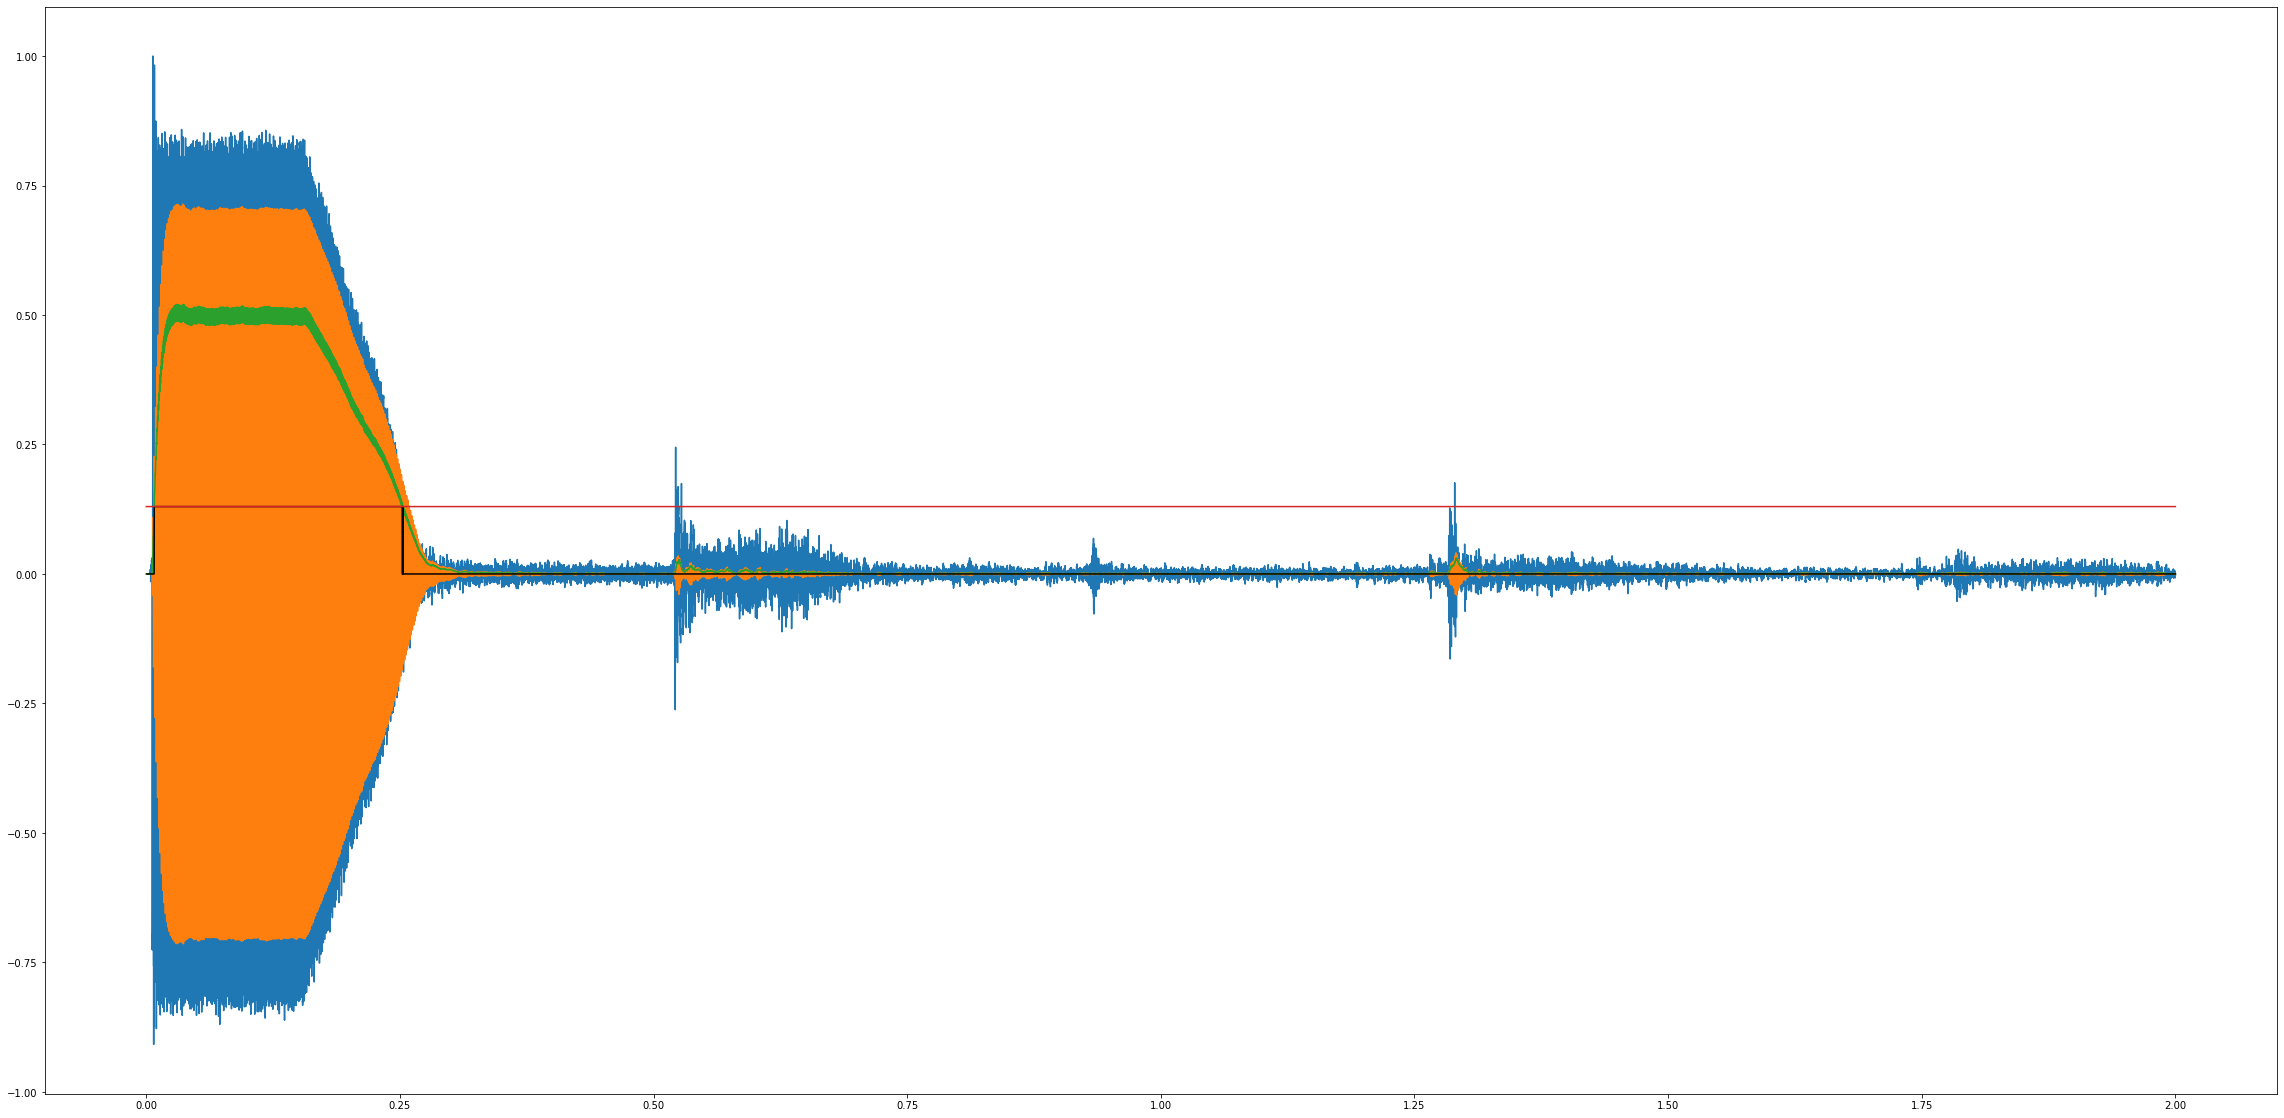

In [538]:
signal = butter_bandpass_filter(left, 775, 825, params.framerate, order=1)
plt.figure(figsize=(40, 20))
n=30
rms = rolling_rms(signal, n=n)
rms = rms

thresh = max(.25*np.max(rms), .05)

plt.plot(times, left, 'C0')
plt.plot(times, signal, 'C1')
plt.plot(times[n:], rms, 'C2')
plt.plot(times[n:], (rms > thresh )*thresh, 'k')
plt.plot(times, np.ones(left.shape) * thresh, 'C3')
plt.show()

In [539]:
get_beep_time(file)

0.2446031746031746

In [540]:
def get_beep_time(file: str, 
                  region: float = 1.0, 
                  low: float = 775,
                  high: int = 825,
                  n: int = 30,
                  start: float = .1):
    '''
    Get approximate duration of beep in seconds
    '''
    
    left, _, params = wavLoad(file)
    left = left[:int(region * params.framerate)]
    left /= np.max(np.abs(left))
    
    signal = butter_bandpass_filter(left, low, high, params.framerate, order=1)
    rms = rolling_rms(signal, n=n)
    
    #thresh = np.mean(rms) + np.std(rms, ddof=1)
    thresh = max(.25*np.max(rms), .05)
    beeps = contiguous_regions( rms > thresh )
    durations = [b[1] - b[0] for b in beeps if b[0] < start*params.framerate]
        
    if len(durations):
        return max(durations) / params.framerate
    else:
        return 0

def get_beep_times(sub, exp, sess, **kwargs):
    files = glob(f"/data/eeg/{sub}/behavioral/{exp}/session_{sess}/[0-5].wav")
    data = {}
    for f in files:
        data[f] = get_beep_time(f, **kwargs)
    return data

In [541]:
index = get_data_index('r1')
FR_subs = index[index.experiment.str.contains('FR1')]

data = apply_to_index(FR_subs, partial(get_beep_times))

Error with catFR1:5 for R1491T



In [542]:
import pickle

with open("beep_times.pkl", "wb") as f:
    pickle.dump(data, f)

In [543]:
data

{'R1001P': {'FR1': {0: {'/data/eeg/R1001P/behavioral/FR1/session_0/0.wav': 0.023333333333333334,
    '/data/eeg/R1001P/behavioral/FR1/session_0/1.wav': 0.024489795918367346,
    '/data/eeg/R1001P/behavioral/FR1/session_0/2.wav': 0.02331065759637188,
    '/data/eeg/R1001P/behavioral/FR1/session_0/3.wav': 0.022653061224489797,
    '/data/eeg/R1001P/behavioral/FR1/session_0/4.wav': 0.02346938775510204,
    '/data/eeg/R1001P/behavioral/FR1/session_0/5.wav': 0.02272108843537415},
   1: {'/data/eeg/R1001P/behavioral/FR1/session_1/0.wav': 0.06873015873015872,
    '/data/eeg/R1001P/behavioral/FR1/session_1/1.wav': 0.06560090702947846,
    '/data/eeg/R1001P/behavioral/FR1/session_1/2.wav': 0.07120181405895691,
    '/data/eeg/R1001P/behavioral/FR1/session_1/3.wav': 0.07244897959183673,
    '/data/eeg/R1001P/behavioral/FR1/session_1/4.wav': 0.07,
    '/data/eeg/R1001P/behavioral/FR1/session_1/5.wav': 0.07249433106575964}}},
 'R1002P': {'FR1': {0: {'/data/eeg/R1002P/behavioral/FR1/session_0/0.wav'